# Cold bias over the High Mountain of Asia (HMA) in CMIP6

## Import of modules / packages
- [intake](https://intake-esm.readthedocs.io/en/latest/): to access the data 
- [xarray](http://xarray.pydata.org/en/stable/) : to manipulate the data
- [proplot](https://proplot.readthedocs.io/en/latest/) : to make plots
- [xesmf](https://xesmf.readthedocs.io/en/latest/) : to make regrid (works only for **Linux** and **Mac**)
- [dask](https://dask.org/) to do parallelization

In [1]:
import intake 
import xarray as xr
import proplot as plot
import xesmf as xe
import numpy as np

In [1]:
# Optional for parallelization (if you have installed dask)
# Doesn't work with xesmf?

# from dask.distributed import Client
# # client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
# client = Client()
# client

In [2]:
# HMA domain

lonlim = slice(50,120)
latlim = slice(0,60)

## CMIP6 data via Intake ([tuto](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html))
This is possible thanks to the [Pangeo](https://pangeo.io/) project and the [Google Cloud](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets)! (still quite experimental)

Otherwise you have to download the data from https://esgf-node.llnl.gov/search/cmip6/ (official international database, but this is much more tedious).

In [3]:
url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

cat = col.search(
    experiment_id=["historical"],
    table_id="Amon",
    variable_id="tas",
#     source_id=["IPSL-CM6A-LR", "SAM0-UNICON"],
    member_id="r1i1p1f1"
)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
cat

,unique
activity_id,1
institution_id,29
source_id,48
experiment_id,1
member_id,1
table_id,1
variable_id,1
grid_label,3
zstore,48
dcpp_init_year,0


In [5]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AS-RCEC/TaiESM1/historical/r1i...,NaN,20200623
1,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...,NaN,20200720
2,CMIP,AWI,AWI-ESM-1-1-LR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AWI/AWI-ESM-1-1-LR/historical/...,NaN,20200212
3,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/BCC/BCC-CSM2-MR/historical/r1i...,NaN,20181126
4,CMIP,BCC,BCC-ESM1,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/BCC/BCC-ESM1/historical/r1i1p1...,NaN,20181214


In [7]:
dset_dict = cat.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## Get observation

In [8]:
obs = xr.open_dataset('../data/cru_ts4.04.1979.2014.tmp.dat_HMA.nc').tmp
obs

<xarray.DataArray 'tmp' (time: 432, lat: 120, lon: 140)>
[7257600 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 50.25 50.75 51.25 51.75 ... 118.75 119.25 119.75
  * lat      (lat) float32 0.25 0.75 1.25 1.75 2.25 ... 58.25 58.75 59.25 59.75
  * time     (time) datetime64[ns] 1979-01-16 1979-02-15 ... 2014-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Make a common grid of 1°x1°

In [9]:
xe_grid = xe.util.grid_global(1, 1)
grid = xr.DataArray(coords={'lat': xe_grid.lat[:,0].values, 'lon': xe_grid.lon[0].values}, dims=['lat', 'lon'])
grid

<xarray.DataArray (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

## Compute the bias

In [10]:
[key for key in dset_dict.keys()]

['CMIP.NCC.NorCPM1.historical.Amon.gn',
 'CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn',
 'CMIP.AS-RCEC.TaiESM1.historical.Amon.gn',
 'CMIP.CAS.FGOALS-f3-L.historical.Amon.gr',
 'CMIP.BCC.BCC-ESM1.historical.Amon.gn',
 'CMIP.NCC.NorESM2-LM.historical.Amon.gn',
 'CMIP.SNU.SAM0-UNICON.historical.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3.historical.Amon.gr',
 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn',
 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn',
 'CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn',
 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn',
 'CMIP.KIOST.KIOST-ESM.historical.Amon.gr1',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn',
 'CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr',
 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr',
 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn',
 'CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr',
 'CMIP.NOAA-GFDL.GFDL-ESM4.hist

In [11]:
list_bias = []

# Regrid obs
regridder = xe.Regridder(obs, grid, 'bilinear', periodic=False, reuse_weights=True)
obs_regrid = regridder(obs)

# Check time
n_months = (2014-1979+1)*12
np.testing.assert_equal(n_months, obs.time.size)

for key in dset_dict.keys():
    ds = dset_dict[key]
    
    if ('latitude' in ds.coords):
        ds = ds.rename({'latitude': 'lat'})
    if ('longitude' in ds.coords):
        ds = ds.rename({'longitude': 'lon'})
    if ('height' in ds.coords):
        ds = ds.drop('height')
    
    try:
        da = ds.sel(time=slice('1979','2014'), lon=lonlim, lat=latlim, member_id='r1i1p1f1').tas - 273.15
    
        # Check time
        try:
            np.testing.assert_equal(n_months, da.time.size)

            # Regrid
            regridder = xe.Regridder(da, grid, 'bilinear', periodic=False, reuse_weights=True)
            da_regrid = regridder(da)

            # Compute bias
            bias = da_regrid.mean('time', skipna=False) - obs_regrid.mean('time', skipna=False)

            # Add the model key attribute
            bias = bias.assign_coords({'model':  key.split('.')[2]})

            list_bias.append(bias.sel(lat=latlim, lon=lonlim))

        except AssertionError:
            print(key + ' does not have all the period available!')
            
    except KeyError:
        print(key + ' KeyError raised (might not have the actual period).')

Reuse existing file: bilinear_120x140_180x360.nc
Reuse existing file: bilinear_32x29_180x360.nc
Reuse existing file: bilinear_49x38_180x360.nc
Reuse existing file: bilinear_64x57_180x360.nc
Reuse existing file: bilinear_60x56_180x360.nc
Reuse existing file: bilinear_22x25_180x360.nc
Reuse existing file: bilinear_32x29_180x360.nc
Reuse existing file: bilinear_64x57_180x360.nc
Reuse existing file: bilinear_64x57_180x360.nc
Reuse existing file: bilinear_86x99_180x360.nc
Reuse existing file: bilinear_30x28_180x360.nc
Reuse existing file: bilinear_48x37_180x360.nc
Reuse existing file: bilinear_64x57_180x360.nc
Reuse existing file: bilinear_64x75_180x360.nc
Reuse existing file: bilinear_54x62_180x360.nc
Reuse existing file: bilinear_54x62_180x360.nc
Reuse existing file: bilinear_32x37_180x360.nc
Reuse existing file: bilinear_30x28_180x360.nc
Reuse existing file: bilinear_60x70_180x360.nc
Reuse existing file: bilinear_48x29_180x360.nc
Reuse existing file: bilinear_64x57_180x360.nc
CMIP.E3SM-P

In [14]:
# Concatenate results

tas = xr.concat(list_bias, dim='model')
tas

,Array,Chunk
Bytes,1.55 MB,33.60 kB
Shape,"(46, 60, 70)","(1, 60, 70)"
Count,1061 Tasks,46 Chunks
Type,float64,numpy.ndarray


## Compute the bias

In [16]:
%%time
tas.load()

<xarray.DataArray (model: 46, lat: 60, lon: 70)>
array([[[            nan,             nan,             nan, ...,
         -2.70806094e+01,             nan,             nan],
        [            nan,             nan,             nan, ...,
         -5.11425052e-01,             nan,             nan],
        [            nan,             nan,             nan, ...,
         -1.10024878e+00,             nan,             nan],
        ...,
        [-2.80161395e+00, -2.66809729e+00, -2.52196886e+00, ...,
         -2.37362474e+00, -3.18802999e+00, -3.42090064e+00],
        [-3.13050839e+00, -3.03362642e+00, -3.06248113e+00, ...,
         -4.60886564e+00, -6.12315263e+00, -5.75411219e+00],
        [-3.42137640e+00, -3.54240113e+00, -3.55391048e+00, ...,
         -5.09838555e+00, -6.34731538e+00, -7.13368842e+00]],

       [[            nan,             nan,             nan, ...,
          1.52082445e+00,             nan,             nan],
        [            nan,             nan,             nan, ...,
          1.48315202e+00,             nan,             nan],
        [            nan,             nan,             nan, ...,
          6.86656922e-01,             nan,             nan],
...
        [-3.68323439e+00, -8.12631215e-01, -7.18981608e-01, ...,
          3.67868300e+00,  2.82290731e+00,  2.58532862e+00],
        [-3.06688359e+00, -9.22047198e-01, -1.00105874e+00, ...,
          1.74297437e+00,  2.24550966e-01,  6.83615394e-01],
        [-2.38487974e+00, -1.18819993e+00, -1.23170724e+00, ...,
          1.58481281e+00,  4.23687838e-01, -1.94213345e-01]],

       [[            nan,             nan,             nan, ...,
         -6.72880972e-01,             nan,             nan],
        [            nan,             nan,             nan, ...,
         -1.73837026e-01,             nan,             nan],
        [            nan,             nan,             nan, ...,
         -7.64151555e-01,             nan,             nan],
        ...,
        [ 5.30366649e-01,  6.30783305e-01,  7.74199844e-01, ...,
          3.04573796e+00,  2.12188097e+00,  2.01983332e+00],
        [ 2.98419327e-01,  3.77781257e-01,  3.66575153e-01, ...,
          1.89973680e+00,  5.78106821e-01,  1.14517511e+00],
        [ 1.76412056e-01,  6.89231382e-02,  1.16365756e-01, ...,
          2.03705617e+00,  1.23518352e+00,  6.62061236e-01]]])
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * lat        (lat) float64 0.5 1.5 2.5 3.5 4.5 ... 55.5 56.5 57.5 58.5 59.5
  * lon        (lon) float64 50.5 51.5 52.5 53.5 ... 116.5 117.5 118.5 119.5
  * model      (model) object 'NorCPM1' 'ACCESS-ESM1-5' ... 'MIROC6' 'CIESM'

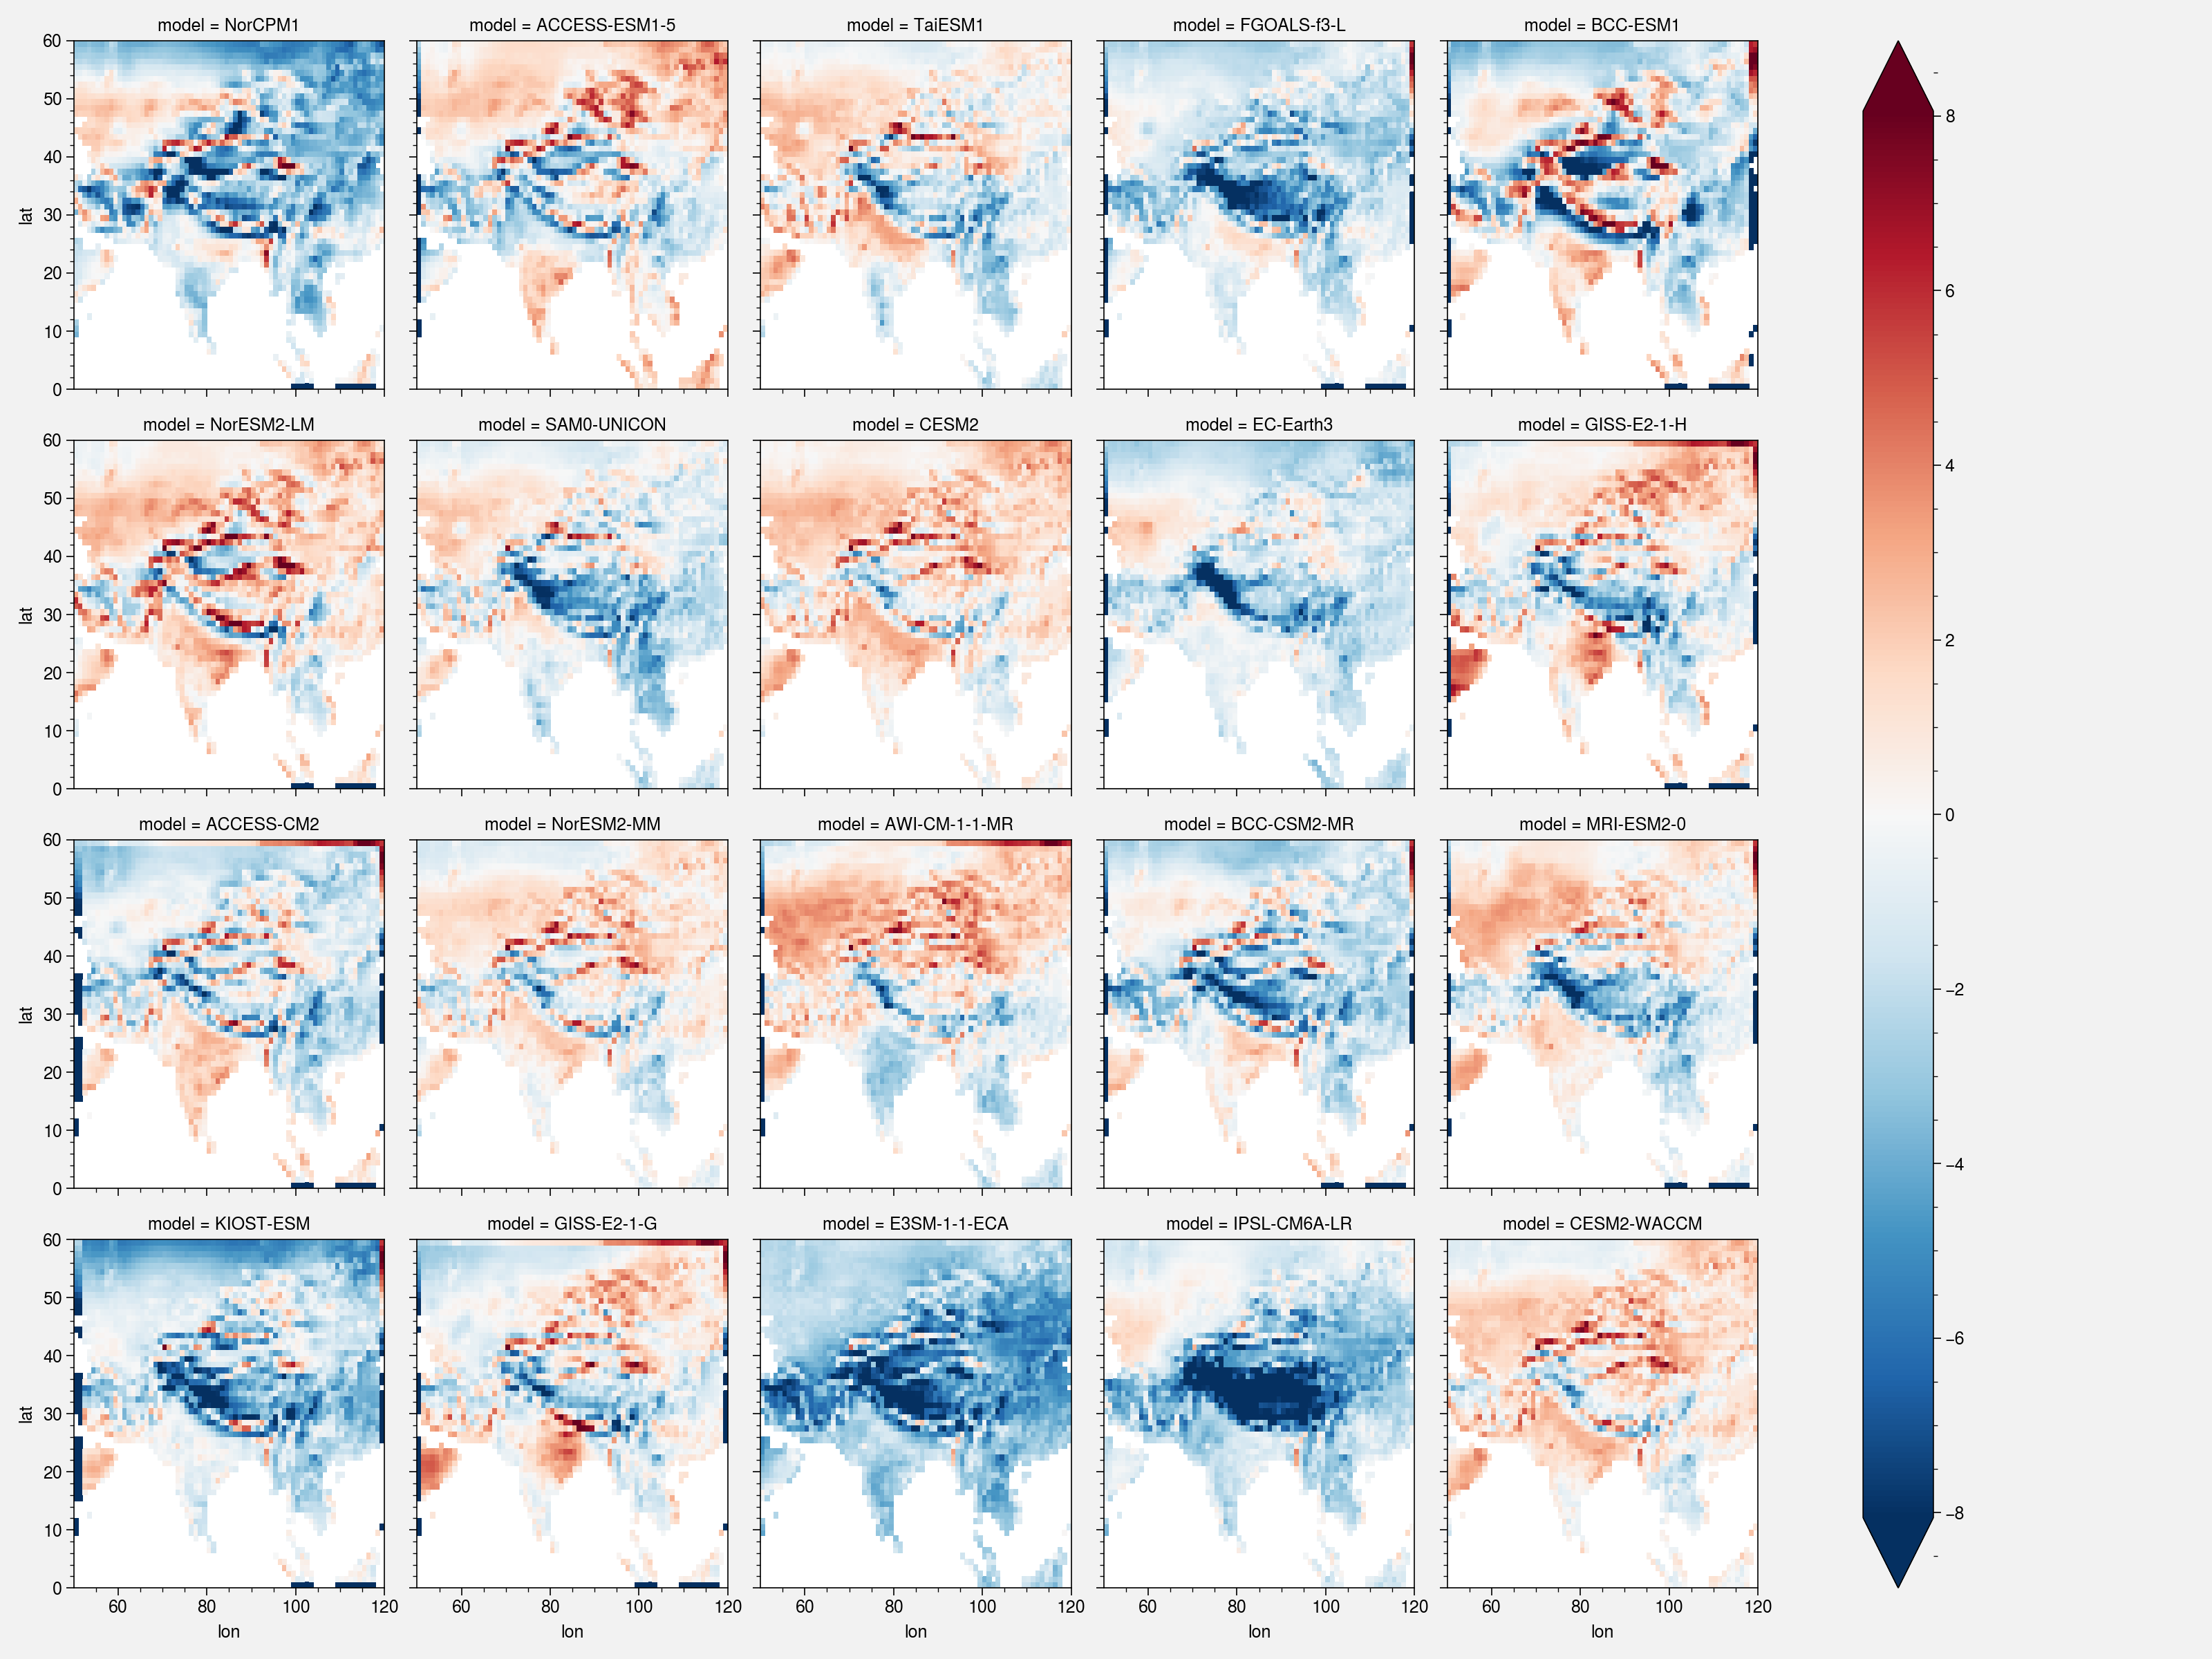

In [28]:
tas[:20].plot(col='model', col_wrap=5, robust=True)

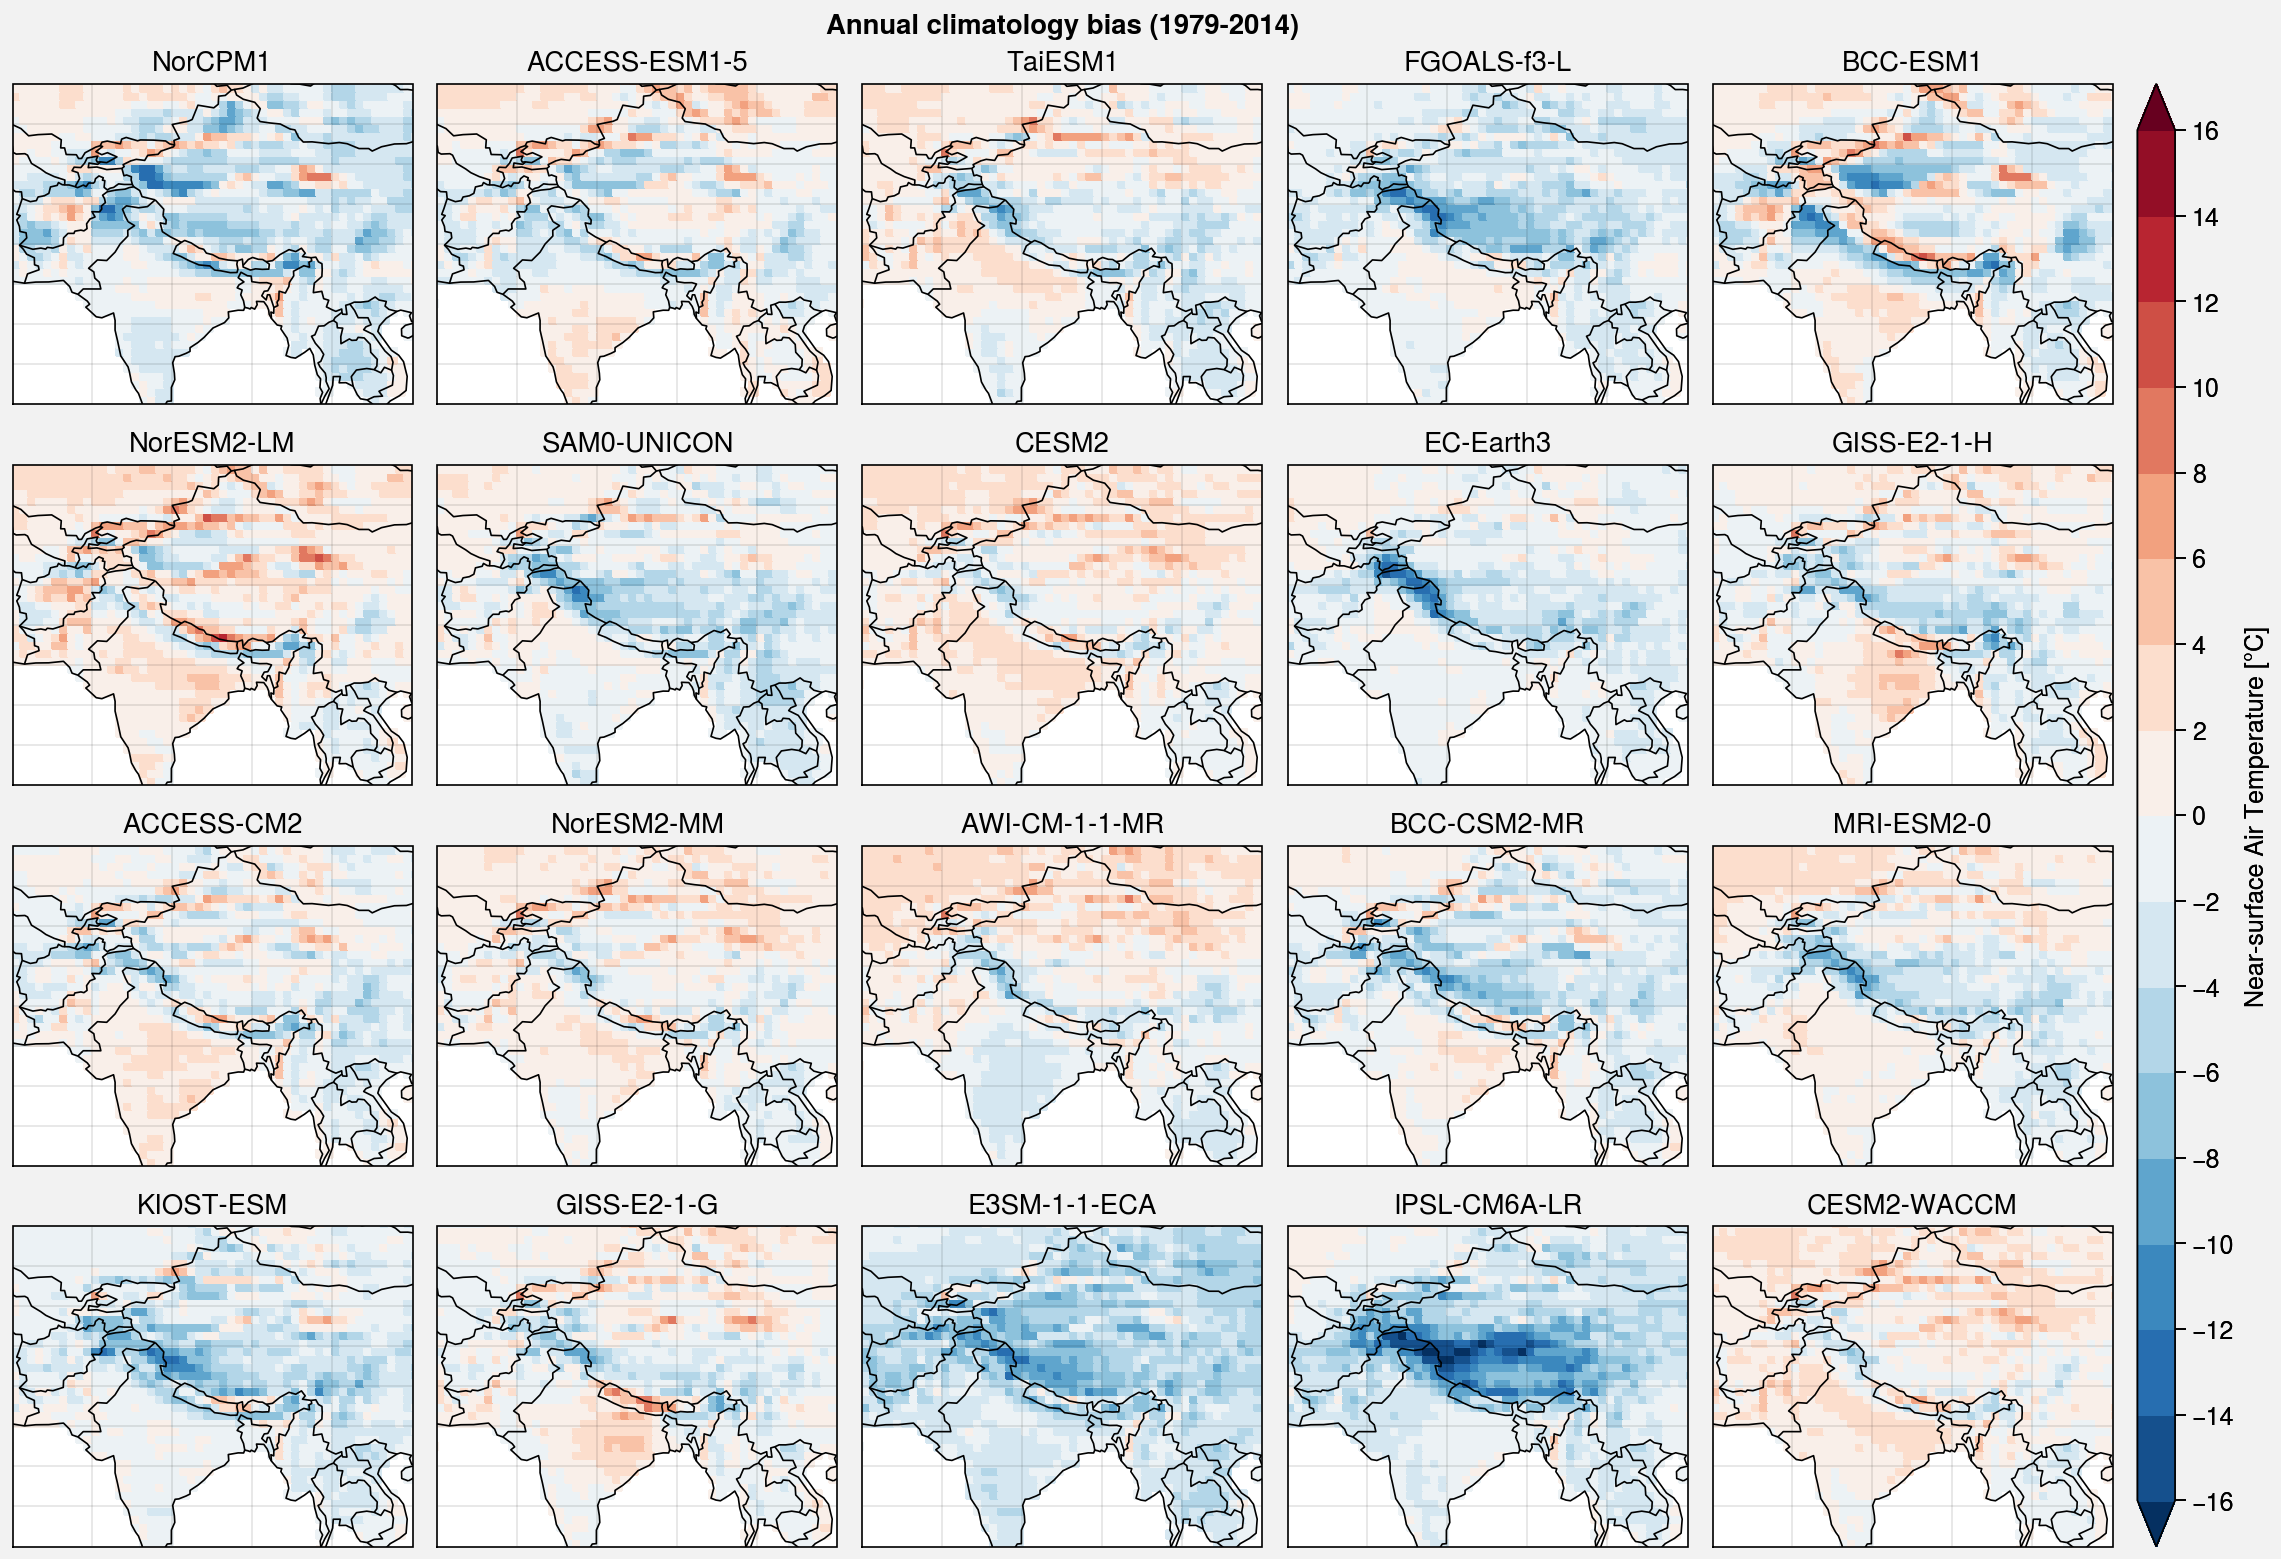

In [30]:
fig, axs = plot.subplots(proj='cyl', axwidth=2, ncols=5, nrows=4)

levels = plot.arange(-16,16,2)
extend = 'both'

for i, model in enumerate(tas[:20].model.values):
    m = axs[i].pcolormesh(tas.sel(model=model), cmap='BuRd', levels=levels, extend=extend)
    axs[i].format(title=model)

fig.colorbar(m, label='Near-surface Air Temperature [°C]')
    
axs.format(
    borders=True, coast=True, labels=False,
    lonlim=(lonlim.start+10, lonlim.stop-10), latlim=(latlim.start+10, latlim.stop-10),
    suptitle='Annual climatology bias (1979-2014)', abc=False
)

## Close the Dask client

In [42]:
# client.close()